## Final project: Book Genre Classification

---------------------------

Clàudia Pintos Relat

---------------------------



### 1. Introduction / overview

The aim of this project was to build a system that can identify the genre of a book based on its synopsis. To develop a book classification task I used a dataset with the summaries of each title (https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset/data) and I tried to identify a set of features that established the genre of a particular book.

The multi-classification task was done by predicting the genre (among five) of the books, after preprocessing their summaries and a previous descriptive analysys of the dataset that gave me some insights about what features can charcaterize more a genre. For doing so, I started by training a RandomForestClassifier, and then two XgboostClssifiers with different inputs, to check which features based on the summaries (the tokens, the entities, the average summary length per genre) improved the predictibilty of the model. Finally, I used a pre-trained Bert model, to find a better classification with DL and also, so that its analysis would not only focus on the word-level semantics, but also on the syntactic structure of the summaries. I compared the performance of the four models by finding the acuraccy, precision, recall and F1 score for each.

I chose accuracy, precision, recall, and f1 as the evaluation metrics for the models because they are widely used in natural language processing (NLP) tasks and provide a comprehensive evaluation of the model's performance. Accuracy is a common metric that measures the percentage of correctly classified samples, while precision and recall are useful to evaluate the model's ability to correctly identify positive samples and avoid false positives and false negatives. F1 score, which is the harmonic mean of precision and recall, provides an overall measure of the model's performance, taking into account both precision and recall.

In this specific case, I am dealing with a multi-class classification problem, and the classes are not balanced, so using accuracy alone is not enough. That's why I also included precision, recall, and f1 score. By using these metrics, I can better assess the models' performance and compare them more effectively.

### 2. Workflow:

1. Import libraries and the dataset.
2. Clean and standardize the data.
    - Data exploration
    - Drop unnecessary columns
    - Rename columns
    - Create a function to classify the different genres between "fiction" and "non fiction".
    - Visualize the count of each group
    - Create a subset with only the category with more samples.
    - Make a function to standardize the genre column.
    - Check the value_counts for each genre and plot it.
    - Keep only the genres that have enough data.
    - If necessary, import another book dataset to add more samples to each genre. 
3. Text preprocessing with nltk.
4. Descriptive analysis of the contents with Spacy
5. Import dataset into MySQLWorkbench and make some queries
6. Feature Extraction: convert the preprocessed text into numerical features that machine learning models can understand. TF-IDF (Term Frequency-Inverse Document Frequency) to represent each book summary.
7. Train-test split.
8. Model 1: train and test.
9. Model 2: train and test.
10. Model 3: train and test.
11. Evaluation: compare the performance and the results of each model: accuracy, precision, recall and F1 score.
12. Next steps (hyperparameter tuning, ensamble methods) or possible errors or bias to be considered.
13. Conclusions.


### 3. Import libraries and the dataset

In [1]:
# Import libraries

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
import seaborn as sns
import numpy as np
import re
import os

In [2]:
# Import more libraries and create a dataframe with a txt file

import pandas as pd
import csv
from tqdm import tqdm

file_path = "/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data/booksummaries.txt"

# Initialize an empty list to store data
sm = []

with open(file_path) as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        # Append the row to the list
        sm.append(row)

# Convert the list of lists to a DataFrame
sums = pd.DataFrame(sm)

# Display the DataFrame
sums.head()

0it [00:00, ?it/s]

16559it [00:00, 17335.42it/s]


,0,1,2,3,4,5,6
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


### 4. Explore and preprocess the dataframe

In [3]:
sums.shape

(16559, 7)

In [4]:
sums.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
6    object
dtype: object

In [5]:
sums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       16559 non-null  object
 1   1       16559 non-null  object
 2   2       16559 non-null  object
 3   3       16559 non-null  object
 4   4       16559 non-null  object
 5   5       16559 non-null  object
 6   6       16559 non-null  object
dtypes: object(7)
memory usage: 905.7+ KB


In [6]:
sums.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

In [7]:
sums.duplicated().sum()

0

In [8]:
sums.columns

RangeIndex(start=0, stop=7, step=1)

In [9]:
# We drop the columns that are not necessary for our analysis (Wikipedia article ID, Freebase ID, author & year of publication):

clean = sums.drop(columns=[0, 1, 3, 4])
clean.head(2)

,2,5,6
0,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."


In [10]:
# We change the name of the columns.

clean.columns = ['title', 'genre', 'summary']
clean.sample(2)

,title,genre,summary
12589,Sign of the Cross,"{""/m/01jfsb"": ""Thriller""}","Jonathon Payne and David ""D.J."" Jones are rec..."
15783,Outerbridge Reach,,"Stone's incisive, haunting novel follows the ..."


In [11]:
list(set(clean['summary']))[0]

" When Edith Howland's husband abandons her for a younger woman, leaving her with their alcoholic son and his senile uncle, she begins recording details of an imaginary, much more successful life where she has friends and grandchildren. However, this diversion soon grows unhealthy when she becomes slowly convinced that the fantasies are real…"

### 5. Data transformation

#### 5.1. First dataset

In [12]:
# We create a function to classify the genres between 'fiction' and 'non fiction'. 

def fiction(string):
    
    fiction_keywords = ['fiction', 'cyberpunk', 'steampunk', 'novel', 'alien invasion', 'literature', 'western', 'fairy tale', 'magic realism', 'roman', 'literary realism', 'prose', 'science fiction', 'fantasy', 'comedy', 'horror', 
                        'adventure', 'thriller', 'crime', 'humour', 'satire', 'gothic', 'young adult', 'mystery', 
                        'novella', 'suspense', 'dystopia', 'romance', 'humour', 'chivalric', 'chick lit', 'story', 
                        'parody', 'drama', 'mystery', 'romantic', 'bildungsroman', 'sea story']
    non_fiction_keywords = ['non-fiction', 'non fiction', 'self-help', 'self help', 'nonfiction']

    # Check if 'non-fiction' is present in the lowercase string
    if any(keyword in string.lower() for keyword in non_fiction_keywords):
        return 'non-fiction'
    # Check if any fiction keyword is present in the lowercase string
    elif any(keyword in string.lower() for keyword in fiction_keywords):
        return 'fiction'
    else:
        return 'non-fiction'


In [13]:
clean['field'] = clean['genre'].apply(fiction)
clean.sample(4)

,title,genre,summary,field
5709,Catastrophea,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",The Doctor and Jo arrive at a planet named Ka...,fiction
6607,Hex,"{""/m/06n90"": ""Science Fiction"", ""/m/0dwly"": ""C...",The story opens with the introduction of a br...,fiction
3934,Candy,,"Candy Christian, aged eighteen, is an extreme...",non-fiction
10404,A fekete város,,"Before Rákóczi's war of liberty, during a hun...",non-fiction


In [14]:
genre_count = clean.field.value_counts()
genre_count

field
fiction        12275
non-fiction     4284
Name: count, dtype: int64

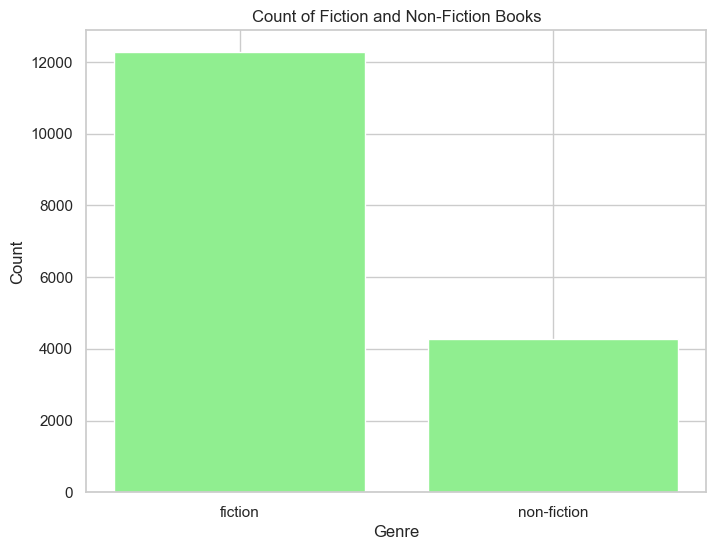

In [28]:
# Set the figsize parameter to control the size of the figure
plt.figure(figsize=(8, 6))

# Plot the count of fiction and non-fiction books
bar_width = 0.05

plt.bar(genre_count.index, genre_count.values, color='lightgreen')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Fiction and Non-Fiction Books')
plt.show()

In [81]:
clean.field.unique()

array(['fiction', 'non-fiction'], dtype=object)

In [82]:
clean.to_csv("tableau.csv", index=False)

# Specify the folder path and filename for the CSV file
folder_path = "/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data"
file_name = "tableau.csv"

# Combine the folder path and filename to create the full file path
full_file_path = f"{folder_path}/{file_name}"

# Export the DataFrame to the specified folder
clean.to_csv(full_file_path, index=False)

In [29]:
# There is more data in the fiction category, so I'm going to create a new dataframe with only the fiction books.
# My models will only be trained with the fiction genres.

fiction = clean[clean['field'] != 'non-fiction']

In [30]:
fiction = fiction.drop(columns=['field'])
fiction.shape

(12275, 3)

In [31]:
def genre_lists(string):
    fan = ['dystopia', 'cyberpunk', 'steampunk', 'alien invasion', 'apocalyptic', 'science fiction', 'fantasy', 'horror', 'gothic']
    thriller = ['thriller', 'crime fiction', 'suspense', 'spy fiction', 'detective fiction', 'mystery']
    true_crime = ['true crime']
    historical = ['historical', 'history', 'western']
    romance = ['chivalric', 'romantic', 'romance', 'erotica', 'pornography']
    comical = ['comedy', 'comical', 'comic novel', 'black comedy', 'humour', 'parody', 'satire']
    poetry = ['poetry']
    travel = ['travel literature']
    children = ["children's literature", 'fairy tale']
    lit = ['magic realism', 'roman', 'literary realism', 'prose']


    genre_lower = string.lower()

    if any(keyword in genre_lower for keyword in fan):
        if 'horror' in genre_lower or 'gothic' in genre_lower:
            return 'horror'
        else:
            return 'fantasy & science fiction'
    elif any(keyword in genre_lower for keyword in thriller):
        return 'thriller'
    elif any(keyword in genre_lower for keyword in true_crime):
        return 'true crime'
    elif any(keyword in genre_lower for keyword in historical):
        return 'historical novel'
    elif any(keyword in genre_lower for keyword in romance):
        return 'romance novel'
    elif any(keyword in genre_lower for keyword in comical):
        return 'comedy'
    elif any(keyword in genre_lower for keyword in poetry):
        return 'poetry'
    elif 'ergodic' in string.lower():
        return 'ergodic'
    elif any(keyword in genre_lower for keyword in children):
        return 'children literature'
    elif any(keyword in genre_lower for keyword in lit):
        return 'literary fiction'
    else:
        return 'literary fiction'

# clean['genre'] = clean['genre'].apply(genre_lists)
 

In [32]:
fiction['standard_genre'] = fiction['genre'].apply(genre_lists)

In [33]:
fiction.sample(4)

,title,genre,summary,standard_genre
13938,Monk's Hood,"{""/m/02n4kr"": ""Mystery""}",The book is set in the late autumn and winter...,thriller
6653,A Taste for Death,"{""/m/02n4kr"": ""Mystery"", ""/m/06wkf"": ""Spy fict...",Canadian Dinah Pilgrim (blind since 11) and h...,thriller
8746,The Flesh in the Furnace,"{""/m/014dfn"": ""Speculative fiction"", ""/m/03npn...",A puppet master has his hands full when his p...,horror
4173,Who?,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",In the historical development leading up to t...,fantasy & science fiction


In [34]:
fiction.standard_genre.value_counts()

standard_genre
fantasy & science fiction    4546
literary fiction             2819
thriller                     2056
children literature           929
historical novel              873
horror                        590
comedy                        231
romance novel                 204
true crime                     13
poetry                         12
ergodic                         2
Name: count, dtype: int64

In [35]:
fiction.shape

(12275, 4)

In [36]:
# We'll drop the "true crime", "ergodic" and "poetry" books because there aren't many samples of each.

novel = fiction[~fiction['standard_genre'].isin(['true crime', 'ergodic', 'poetry'])]
novel.shape

(12248, 4)

In [37]:
novel.standard_genre.value_counts()

standard_genre
fantasy & science fiction    4546
literary fiction             2819
thriller                     2056
children literature           929
historical novel              873
horror                        590
comedy                        231
romance novel                 204
Name: count, dtype: int64

I'll drop the category of 'children literature' because it really doesn't give us information about the topic, 
but rather the age of the target readers.

In [38]:
adults = novel[~novel['standard_genre'].isin(['children literature'])]
adults.shape

(11319, 4)

In [39]:
adults_count = adults.standard_genre.value_counts()
adults_count

standard_genre
fantasy & science fiction    4546
literary fiction             2819
thriller                     2056
historical novel              873
horror                        590
comedy                        231
romance novel                 204
Name: count, dtype: int64

In [40]:
adults.sample(3)

,title,genre,summary,standard_genre
9907,Passage to Pluto,"{""/m/06n90"": ""Science Fiction""}",Chris Godfrey is now deputy-director of UNEXA...,fantasy & science fiction
13011,Oceanic,"{""/m/06n90"": ""Science Fiction""}","The story follows Martin, a Freelander living...",fantasy & science fiction
7398,Across the Sea of Suns,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",Radio astronomy on the Moon in 2021 reveals t...,fantasy & science fiction


In [41]:
# I create a function to clean the standard_genre of 'fantasy & science fiction'.

def fant_sci(string):
    sci_fi_keywords = ['dystopia', 'cyberpunk', 'steampunk', 'alien invasion', 'apocalyptic']
    
    genre_lower = string.lower()

    if any(keyword in genre_lower for keyword in sci_fi_keywords):
        return 'science fiction'
    elif 'fantasy' in genre_lower and 'science fiction' not in genre_lower:
        return 'fantasy'
    elif 'science fiction' in genre_lower and 'fantasy' not in genre_lower:
        return 'science fiction'
    else:
        return 'fantasy & science fiction'

In [42]:
fant_mask = adults['standard_genre'] == 'fantasy & science fiction'
adults.loc[fant_mask, 'standard_genre'] = adults.loc[fant_mask, 'genre'].apply(fant_sci)
adults.sample(5)

,title,genre,summary,standard_genre
7931,Kaaterskill Falls,"{""/m/02xlf"": ""Fiction"", ""/m/05hgj"": ""Novel""}",Kaaterskill Falls spans two years (summer 197...,literary fiction
14216,Ransom My Heart,"{""/m/03mfnf"": ""Young adult literature""}",When the feisty but beautiful maiden Finnula ...,literary fiction
2883,Pigs in Heaven,"{""/m/02xlf"": ""Fiction"", ""/m/05hgj"": ""Novel""}",This novel begins two years after the events ...,literary fiction
1937,Idoru,"{""/m/01qpc"": ""Cyberpunk"", ""/m/06n90"": ""Science...",In the post Tokyo/San Francisco earthquake wo...,science fiction
6225,Toxin,"{""/m/01jfsb"": ""Thriller"", ""/m/05hgj"": ""Novel"",...",The book opens with a scene showing a couple ...,thriller


In [43]:
adults_count = adults.standard_genre.value_counts()
adults_count

standard_genre
literary fiction             2819
science fiction              2302
thriller                     2056
fantasy                      1695
historical novel              873
horror                        590
fantasy & science fiction     549
comedy                        231
romance novel                 204
Name: count, dtype: int64

In [44]:
# I drop the three lasts genres (the ones that have less data).
# I want to keep less categories for efficiency purposes or for computer expenses when training.

six_genres = adults[~adults['standard_genre'].isin(['fantasy & science fiction', 'comedy', 'romance novel'])]
six_genres.head(4)

,title,genre,summary,standard_genre
1,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",science fiction
2,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,literary fiction
5,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...",literary fiction
6,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",fantasy


In [45]:
six_count = six_genres.standard_genre.value_counts()
six_count

standard_genre
literary fiction    2819
science fiction     2302
thriller            2056
fantasy             1695
historical novel     873
horror               590
Name: count, dtype: int64

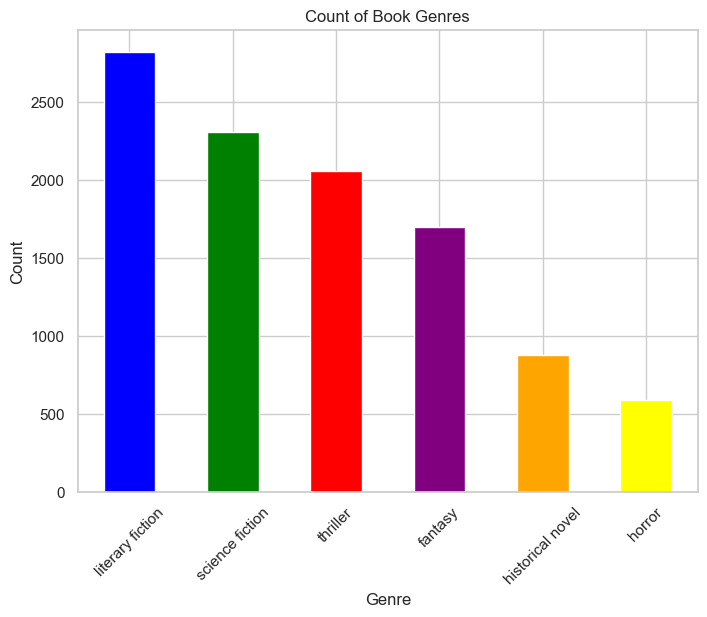

In [46]:
# I'm going to plot the count for each book genre.

# Set the figsize parameter to control the size of the figure
plt.figure(figsize=(8, 6))

six_count.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange', 'yellow'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Book Genres')
plt.xticks(rotation=45) 
plt.show()

In [47]:
six_genres.shape

(10335, 4)

In [48]:
six_genres.sample(2)

,title,genre,summary,standard_genre
7051,The Wheels of Chance,"{""/m/06n90"": ""Science Fiction"", ""/m/01z4y"": ""C...",The Wheels of Chance was written at the heigh...,science fiction
1976,Thrilling Cities,"{""/m/04z2hx"": ""Travel literature""}",Thrilling Cities is Ian Fleming's view of thi...,literary fiction


In [49]:
six = six_genres.drop(columns='genre')

In [50]:
six.sample(4)

,title,summary,standard_genre
2367,Celebrated Cases of Judge Dee,There are three cases in this book. The first...,thriller
9845,Not in the Flesh,"Searching for truffles in a wood, a man and h...",thriller
15449,The Rose in Splendour: a Story of the Wars of ...,The novel is set in England over a period of ...,historical novel
350,The Legend of Sleepy Hollow,"""From the listless repose of the place, and t...",literary fiction


In [51]:
six.rename(columns={'standard_genre': 'genre'}, inplace=True)
six.head(2)

,title,summary,genre
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",science fiction
2,The Plague,The text of The Plague is divided into five p...,literary fiction


#### 5.2. I import a new dataset to increase my book genre samples.

In [52]:
books = pd.read_csv("/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data/more_books.csv")
books.head(5)

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [53]:
books.genre.value_counts()

genre
thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: count, dtype: int64

In [54]:
books = books.drop(columns='index')
books.shape

(4657, 3)

In [55]:
# I want to check if in this new dataset, the books classified as 'history' are essays or historical novels.

hist = books[books['genre'] == 'history']
hist.head(4)

,title,genre,summary
1500,Smuggler's Moon,history,Sir John and Jeremy are sent to East Anglia t...
1501,An Experiment In Treason,history,A pack of confidential letters is stolen from...
1502,War and Peace,history,"War and Peace has a large cast of characters,..."
1503,The First Sir Percy,history,March 1624 and a lot has happened since the p...


In [56]:
# I can see that they are historical novels. 

list(set(hist.summary))[:10]

[' The story starts before the French revolution. It\'s 1783 and wealthy Paul Déroulède has offended the young Vicomte de Marny by speaking disrepctfully of his latest infatuation, Adèle de Monterchéri. Déroulède had not intended to get into the quarrel but has a tendency to blunder into things -- "no doubt a part of the inheritance bequeathed to him by his bourgeois ancestry." Incensed at the slur on Adèle, whom he sees as a paragon of virtue, the Vicomte challenges Déroulède to a duel, a fight which Déroulède does not want—for he knows and respects the boy\'s father, the Duc de Marny. Swords drawn, the fight ensues in the centre of the salon but despite his noble lineage, the Vicomte de Marny is no match for Déroulède\'s swordplay, especially when addled with wine and rage. Déroulède disarms his opponent and having won the duel, draws back but the boy refuses to back down without complete satisfaction and demands that Déroulède get down on his knees and apologize. Finally losing his 

In [57]:
less = books[~books['genre'].isin(['science', 'crime', 'romance', 'psychology', 'sports', 'travel'])]
less.head(5)

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [58]:
less.shape

(3099, 3)

In [59]:
less.genre.value_counts()

genre
thriller    1023
fantasy      876
history      600
horror       600
Name: count, dtype: int64

In [60]:
# I want to check if in this new dataset, the books classified as 'fantasy' are really fantasy books. 
# Perhaps they are instead "fantasy & science fiction" books. 

fanta = less[less['genre'] == 'fantasy']
fanta.head(4)

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...


In [61]:
# It seems that the books classifies as "fantasy" are really fantasy stories rather than science fiction. 

list(set(fanta.summary))[208]

" In this installment, Miriam Beckstein spends most of her time in the first parallel world, a virtual prisoner. She has ruffled enough feathers and stirred up enough trouble that her uncle, the clan's head of security, keeps her well isolated, and unable to travel unchaperoned. At one point in the story, she manages to escape surveillance for a short time, but she quickly gets herself back in trouble, and her activities are strongly circumscribed thereafter. There's a subplot involving Mike Fleming, a cop who dated Miriam a couple of times. Mike has been pulled into a government task force that is investigating the clan's activities and plans with the help of a member of the clan's security apparatus who turned his back on the clan at the end of book two. There are occasional references to the moral and security implications of holding him prisoner outside the criminal justice system, but they are not explored in any depth."

In [62]:
# I define the new order of columns
new_order = ['title', 'summary', 'genre']

# Reorder columns
less = less[new_order]
less.sample(2)

,title,summary,genre
415,Burning Tower,"The three main characters are Sandry, a Lord ...",fantasy
303,Westmark,It is a complicated and politically dangerous...,fantasy


In [63]:
less.genre.value_counts()

genre
thriller    1023
fantasy      876
history      600
horror       600
Name: count, dtype: int64

In [64]:
six.genre.value_counts()

genre
literary fiction    2819
science fiction     2302
thriller            2056
fantasy             1695
historical novel     873
horror               590
Name: count, dtype: int64

In [65]:
less['genre'] = less['genre'].replace('history', 'historical novel')
less.genre.value_counts()

genre
thriller            1023
fantasy              876
historical novel     600
horror               600
Name: count, dtype: int64

In [66]:
print(six.shape)
less.shape

(10335, 3)


(3099, 3)

#### 5.3. Now I'm going to join the two datasets.

In [67]:
joined = pd.concat([six, less], ignore_index=True)
joined.head(8)

,title,summary,genre
0,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",science fiction
1,The Plague,The text of The Plague is divided into five p...,literary fiction
2,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...",literary fiction
3,A Wizard of Earthsea,"Ged is a young boy on Gont, one of the larger...",fantasy
4,Blade Runner 3: Replicant Night,"Living on Mars, Deckard is acting as a consul...",science fiction
5,Blade Runner 2: The Edge of Human,Beginning several months after the events in ...,science fiction
6,Crash,The story is told through the eyes of narrato...,literary fiction
7,Children of Dune,Nine years after Emperor Paul Muad'dib walked...,science fiction


In [68]:
joined.shape

(13434, 3)

In [69]:
joined.duplicated().sum()

1730

In [70]:
join = joined.drop_duplicates()
join.duplicated().sum()

0

In [71]:
join.shape

(11704, 3)

In [72]:
join.genre.value_counts()

genre
literary fiction    2819
thriller            2634
science fiction     2302
fantasy             2210
historical novel    1048
horror               691
Name: count, dtype: int64

In [73]:
# Maybe we should drop the 'horror' column because it is the category with less samples.
# we want a balanced dataset so that our models are better trained. 

In [74]:
five = join[~join['genre'].isin(['horror'])]
five.shape

(11013, 3)

In [75]:
five_counts = five.genre.value_counts()
five_counts

genre
literary fiction    2819
thriller            2634
science fiction     2302
fantasy             2210
historical novel    1048
Name: count, dtype: int64

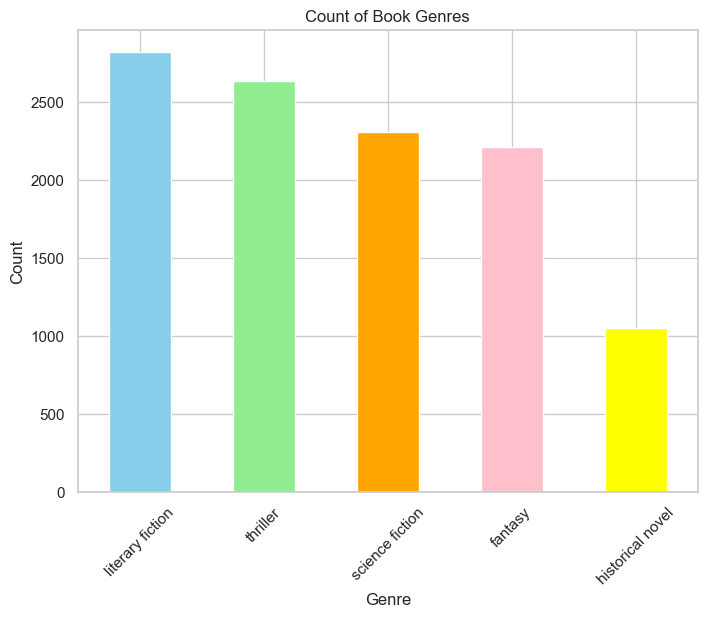

In [79]:
# Set the figsize parameter to control the size of the figure
plt.figure(figsize=(8, 6))

five_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'pink', 'yellow'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Book Genres')
plt.xticks(rotation=45) 
plt.show()

In [ ]:
# I save my dataframe with the changes saved:

five.to_csv("five.csv", index=False)

# Specify the folder path and filename for the CSV file
folder_path = "/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data"
file_name = "five.csv"

# Combine the folder path and filename to create the full file path
full_file_path = f"{folder_path}/{file_name}"

# Export the DataFrame to the specified folder
five.to_csv(full_file_path, index=False)